# Reward design and testing

Training DDQN agents with different rewards. Base reward in the environment is sparse (end reward only). We will try to design dense rewards to help the agent learn faster.

The rewards are implemented in src/rewards.py . 

In [1]:
# Import relevant libraries

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('src/')

import numpy as np
import os
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt

from flatland.envs.line_generators import SparseLineGen
from flatland.envs.malfunction_generators import (
    MalfunctionParameters,
    ParamMalfunctionGen,
)
from flatland.envs.rail_generators import SparseRailGen
from flatland.envs.observations import TreeObsForRailEnv

from src import test_utils, training, rewards
from src.observation_utils import normalize_observation
from src.models import *
from src.deep_model_policy import DeepPolicy, PolicyParameters

## Reward design

We implemented the following rewards:
- 'baseline': the provided flatland sparse reward (end reward).
- 'Dense_base': a dense reward that gives the normalized flatland reward at each step
- 'Collective_base': common reward for all agents, based on the normalized flatland reward
- 'DoubleEnd' : a dense reward that gives the normalized flatland reward at each step, and the flatland reward at the final step
- 'JBR' : the dense reward proposed by the JBR_HSE team in the 2020 challenge (https://arxiv.org/abs/2103.16511)
- 'JBR_1' and 'JBR_2' : variations of the JBR reward with different weights for deadlocks and arrivals
- 'JBR_Norm' : the JBR_2 reward normalized by the number steps
- 'JBR_modified' : the JBR_Norm step reward + flatland reward for the final step

In [61]:
# Retrieve the environments for training on different rewards

test_envs = rewards.get_testing_environments(
    width=25,
    height=25,
    rail_generator=SparseRailGen(
        max_num_cities=2,  # Number of cities
        grid_mode=False,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=5, 
    obs_builder_object=TreeObsForRailEnv(max_depth=2),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=5,  # Minimal duration
            max_duration=20,  # Max duration
        )
    )
)

## Train DDQN policies

In [63]:
# Train this environment for reward_name
reward_name = "DoubleEnd"

env = test_envs[reward_name]

policy_params = PolicyParameters(action_size=5, buffer_size=int(1e5), 
                                 batch_size=128, gamma=0.99, tau=1e-3, 
                                 lr=5e-4, update_every=4, use_gpu=True)
observation_tree_depth = 2
observation_radius = 10
observation_max_path_depth = 30

n_features_per_node = env.obs_builder.observation_dim
n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
state_size = n_features_per_node * n_nodes

model = DuelingQNetwork(state_size, policy_params.action_size, hidsize1=128, hidsize2=128)
policy = DeepPolicy(model, policy_params)

Using CPU


In [64]:
# Train the policy
obs_params = {
    "observation_tree_depth": observation_tree_depth,
    "observation_radius": observation_radius,
}
train_params = {
    "eps_start": 1.0,
    "eps_end": 0.01,
    "eps_decay": 0.99,
    "n_episodes": 1500,
    "checkpoint_interval": 100,
    "n_eval_episodes": 1,
    "restore_replay_buffer": False,
    "save_replay_buffer": False,
    "render": False,
    "buffer_size": int(1e5),
}

In [65]:
if reward_name not in os.listdir('rewards_results/') :
    os.mkdir('rewards_results/' + reward_name)

In [66]:
# Train and save checkpoints
training.train_agent(env, policy, train_params, obs_params, checkpoints_folder='rewards_results/'+reward_name+'/')


💾 Replay buffer status: 0/100000 experiences

🚉 Training 5 trains on 25x25 grid for 1500 episodes, evaluating on 1 episodes every 100 episodes.

🚂 Episode 0	 🏆 Score: -1.378 Avg: -1.004	 💯 Done: 0.00% Avg: 0.00%	 🎲 Epsilon: 0.990 	 🔀 Action Probs: ↻ 0.189 ← 0.245 ↑ 0.212 → 0.198 ◼ 0.156  	✅ Eval: score -0.396 done 60.0%
	🔍 Evaluation score: -0.396 done: 60.0%
🚂 Episode 10	 🏆 Score: -0.719 Avg: -0.989	 💯 Done: 20.00% Avg: 0.96%	 🎲 Epsilon: 0.895 	 🔀 Action Probs: ↻ 0.156 ← 0.247 ↑ 0.169 → 0.247 ◼ 0.182  

KeyboardInterrupt: 

## Test trained policy

In [67]:
policy.load(f'rewards_results/{reward_name}/checkpoint_1499.pth')

In [68]:
# Test with the flatland reward
env = test_envs['baseline']

In [69]:
# Test the policy
n_test = 100

scores, completions, nb_steps, seeds = test_utils.test_policy(env, policy, n_test, obs_params)

	✅ Eval: score -0.138 done 68.0%


In [70]:
# Get best and worst performing seeds
worst_seed = seeds[np.argmin(scores)]
best_seed = seeds[np.argmax(scores)]

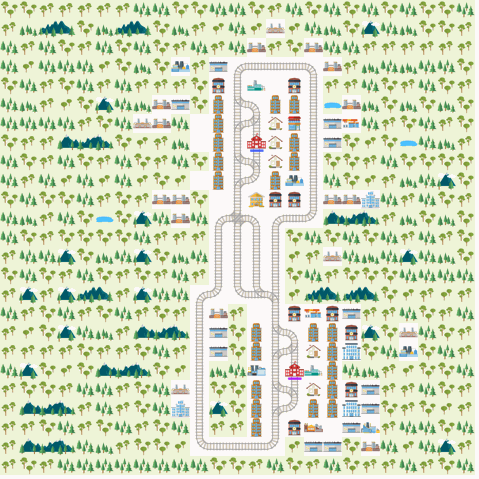

In [71]:
# Test the policy on the worst seed
env_renderer = test_utils.render_one_test(env, policy, obs_params, seed=worst_seed, real_time_render=False, force_gif=True)
env_renderer.make_gif('test')

## Run tests for every checkpoint

In order to compare the learning performances of each reward, we need to evaluate the trained policies on the same test set. We will run the test for each checkpoint of each reward and compare the results.

In [2]:
# Create results.csv
if 'results.csv' not in os.listdir('rewards_results/'):
    results = pd.DataFrame(columns=['env', 'epoch', 'scores', 'completions', 'nb_steps', 'seeds'])
    results.to_csv('rewards_results/results.csv', index=False)

results = pd.read_csv('rewards_results/results.csv')

In [34]:
# Test the policy on all checkpoints
env = test_envs['baseline']
seeds_test = range(2000, 2100)

for test_env in test_envs.keys():
    for epoch in list(range(0, 1499, 100)) + [1499]:
        # If the test has already been done, skip
        print(f"Testing {test_env} at epoch {epoch}")
        if len(results[(results['env'] == test_env) & (results['epoch'] == epoch)]) > 0:
            print('Already tested')
            continue
        policy.load(f'rewards_results/{test_env}/checkpoint_{epoch}.pth')
        n_test = 100
        scores, completions, nb_steps, seeds = test_utils.test_policy(env, policy, n_test, obs_params, seeds=seeds_test)
        row_to_add = {'env': test_env, 'epoch': epoch, 'scores': scores, 'completions': completions, 'nb_steps': nb_steps, 'seeds': seeds}
        results = results.append(row_to_add, ignore_index=True)
        results.to_csv('rewards_results/results.csv', index=False)
print('DONE')

Testing baseline at epoch 0
Already tested
Testing baseline at epoch 100
	✅ Eval: score -0.488 done 13.8%
Testing baseline at epoch 200
Already tested
Testing baseline at epoch 300
	✅ Eval: score -0.484 done 13.6%
Testing baseline at epoch 400
Already tested
Testing baseline at epoch 500
	✅ Eval: score -0.471 done 3.8%
Testing baseline at epoch 600
Already tested
Testing baseline at epoch 700
	✅ Eval: score -0.432 done 12.0%
Testing baseline at epoch 800
Already tested
Testing baseline at epoch 900
	✅ Eval: score -0.101 done 79.4%
Testing baseline at epoch 1000
Already tested
Testing baseline at epoch 1100
	✅ Eval: score -0.112 done 75.8%
Testing baseline at epoch 1200
Already tested
Testing baseline at epoch 1300
	✅ Eval: score -0.322 done 36.0%
Testing baseline at epoch 1400
Already tested
Testing baseline at epoch 1499
Already tested
Testing Collective at epoch 0
Already tested
Testing Collective at epoch 100
	✅ Eval: score -0.495 done 11.0%
Testing Collective at epoch 200
Already t

## Analyze results

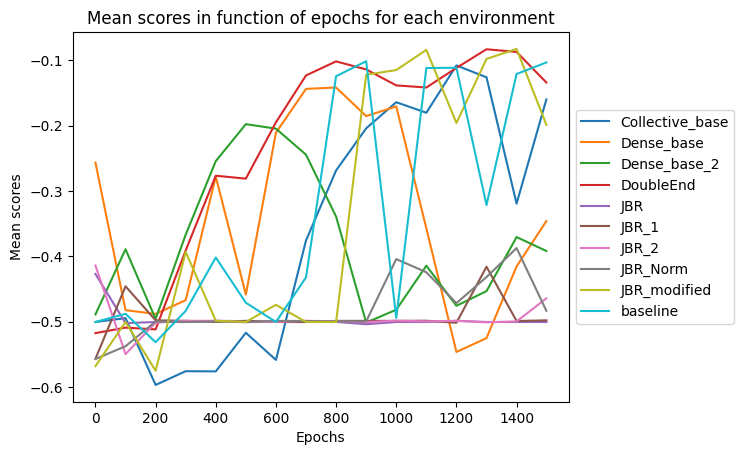

In [13]:
results = pd.read_csv('rewards_results/results.csv')

# Order by env and epoch
results = results.sort_values(by=['env', 'epoch']).reset_index(drop=True)

for col in ['scores', 'completions', 'nb_steps', 'seeds']:
    results[col] = results[col].apply(literal_eval)

# Get the mean of scores and completions
results['mean_scores'] = results['scores'].apply(np.mean)
results['mean_completions'] = results['completions'].apply(np.mean)

# Draw mean scores in function of epochs for each environment
for env in results['env'].unique():
    plt.plot(results[results['env'] == env]['epoch'], results[results['env'] == env]['mean_scores'], label=env)
# print legend next to plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Epochs')
plt.ylabel('Mean scores')
plt.title('Mean scores in function of epochs for each environment')
plt.show()

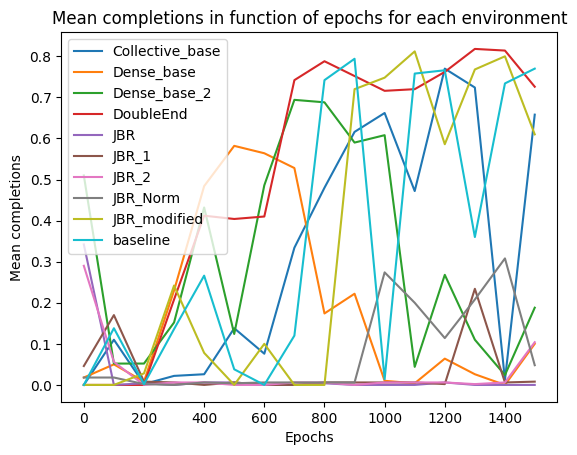

In [4]:
# Draw mean completions in function of epochs for each environment
for env in results['env'].unique():
    plt.plot(results[results['env'] == env]['epoch'], results[results['env'] == env]['mean_completions'], label=env)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean completions')
plt.title('Mean completions in function of epochs for each environment')
plt.show()

### Figures for report

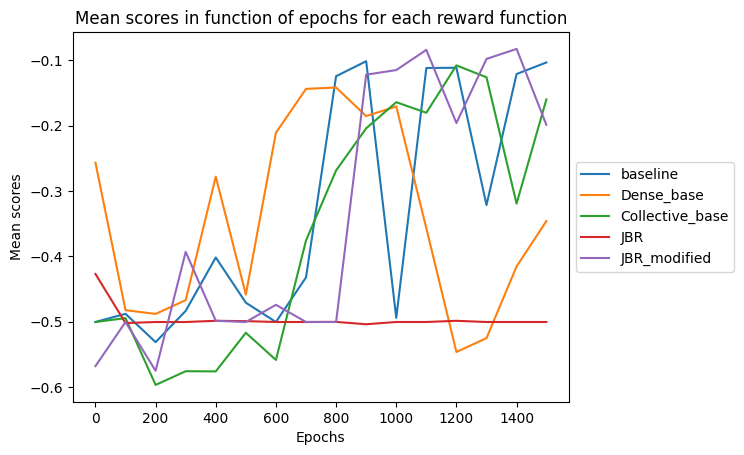

In [11]:
envs_to_plot = ['baseline', 'Dense_base', 'Collective_base', 'JBR', 'JBR_modified']

# Draw mean scores in function of epochs for each environment
for env in envs_to_plot:
    plt.plot(results[results['env'] == env]['epoch'], results[results['env'] == env]['mean_scores'], label=env)
# print legend next to plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Epochs')
plt.ylabel('Mean scores')
plt.title('Mean scores in function of epochs for each reward function')
plt.show()

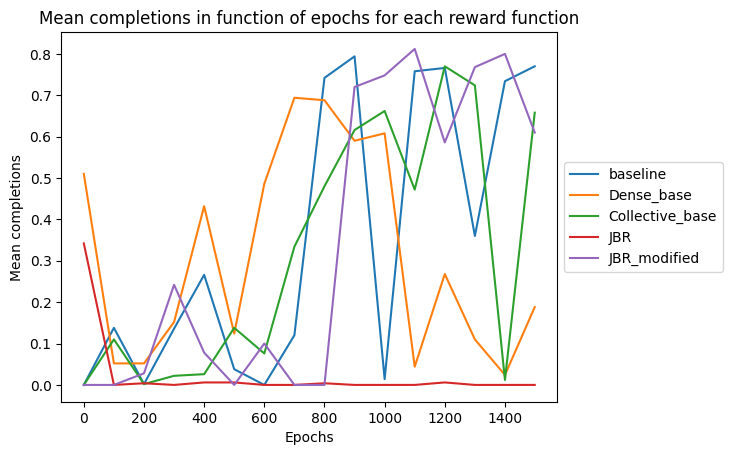

In [14]:
# Draw mean completions in function of epochs for each environment
for env in envs_to_plot:
    plt.plot(results[results['env'] == env]['epoch'], results[results['env'] == env]['mean_completions'], label=env)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Epochs')
plt.ylabel('Mean completions')
plt.title('Mean completions in function of epochs for each reward function')
plt.show()